In [17]:
rm(list = ls())
setwd('./')

library(Seurat)
library(ggplot2)
library(patchwork)
library(dplyr)
library(GSVA)
library(tidyverse)
library(pheatmap)
library(clusterProfiler)
library(RColorBrewer)
library(viridis)
library(ggsignif)

In [18]:
preprocessing <- function(slide) {
  raw_data_directory <- slide
  spatial_object <- Load10X_Spatial(raw_data_directory)
  genes_to_keep <- names(which(Matrix::rowSums(spatial_object@assays$Spatial@counts )>5))
  spatial_object_subset <- subset(spatial_object,features =genes_to_keep, subset = nFeature_Spatial > 300)
  cat("Spots removed: ", ncol(spatial_object) - ncol(spatial_object_subset), "\n")
  cat("Genes kept: ", length(genes_to_keep),"from",nrow(spatial_object), "\n")  
  spatial_object_subset <- SCTransform(spatial_object_subset, assay = "Spatial")
  return(spatial_object_subset)
}

feature_plot <- function(sce, gene_sets_list) {
    exp<- as.matrix(sce@assays$Spatial@counts)
    matrix <- gsva(exp,gene_sets_list,kcdf="Poisson",method="ssgsea",abs.ranking=T ,parallel.sz=8)
    # matrix <- gsva(exp,gene_sets_list,kcdf="Poisson",method="gsva",abs.ranking=T ,parallel.sz=8)

    sce$sc_str=matrix[1,]
    p0 <- SpatialFeaturePlot(sce,features = 'sc_str',alpha = 0, stroke=NA)
    p <- SpatialFeaturePlot(sce,features = 'sc_str',alpha = 0.9, stroke=NA) + scale_fill_viridis()
    p1 <- SpatialFeaturePlot(sce,features = 'sc_str',alpha = 0.9, stroke=NA,min.cutoff = 'q5') + scale_fill_viridis()
    p2 <- SpatialFeaturePlot(sce,features = 'sc_str',alpha = 0.9, 
                             stroke=NA,min.cutoff = 'q5',max.cutoff = 'q95') + scale_fill_viridis()
    return(list(p0,p,p1,p2))
}

In [19]:
load('./data/processed/str_scissor_degs.Rdata')
degs$gene <- rownames(degs)
degs$v <- -log10(degs$p_val_adj)
degs$pct <- (degs$pct.1 - degs$pct.2)
degs$group <- ifelse((degs$p_val_adj < 0.05) & (degs$avg_log2FC > 1.5),'Up','Down/NS')
sig_degs <- subset(degs, p_val_adj < 0.05 & degs$avg_log2FC > 1.5)

gs <- list(scSTR=rownames(sig_degs))

rownames(sig_degs[order(sig_degs$avg_log2FC, decreasing=T),])

gene_list=rownames(sig_degs)
gene_sets_list <- list(
    sc_str = gene_list
    )

[1] "COL1A1"  "TAGLN"   "CTHRC1"  "COL3A1"  "COL1A2"  "THBS2"   "BGN"    
 [8] "GJB2"    "ACTA2"   "FN1"     "POSTN"   "TPM2"    "INHBA"   "TPM1"   
[15] "COL5A2"  "COL11A1" "SPARC"   "COL12A1" "COL6A3"  "SFRP4"   "ACTG2"  
[22] "COL5A1"

In [20]:
res_folder = "./data/raw/Spatial/"
root_path = "./data/raw/Spatial/Pathology_SpotAnnotations"

pid_list <- list(
  'V10B01-048_0' = list(st_id = 'SN048_A121573_Rep1',
                        anno_list = c('epithelium&submucosa','IC aggregregate_submucosa',
                                      'non neo epithelium','stroma_fibroblastic_IC high',
                                      'submucosa','tumor','tumor&stroma_IC med to high'),
                        level_list = c('stroma_fibroblastic_IC high','tumor&stroma_IC med to high',
                                       'tumor','epithelium&submucosa','IC aggregregate_submucosa',
                                       'non neo epithelium','submucosa'),
                        label_list = c('Stroma','Tumor&Stroma','Tumor',
                                       'Normal','Normal','Normal','Normal')
                        ),
  'V10B01-048_1' = list(st_id = 'SN048_A121573_Rep2',
                        anno_list = c('epithelium&submucosa','non neo epithelium',
                                      'stroma_fibroblastic_IC high','submucosa',
                                      'tumor','tumor&stroma_IC med to high'),
                        level_list = c('stroma_fibroblastic_IC high','tumor&stroma_IC med to high',
                                       'tumor','epithelium&submucosa',
                                       'non neo epithelium','submucosa'),
                        label_list = c('Stroma','Tumor&Stroma','Tumor',
                                       'Normal','Normal','Normal')
                        ),
  'V10B01-048_2' = list(st_id = 'SN048_A416371_Rep1',
                        anno_list = c('stroma_fibroblastic_IC high','stroma_fibroblastic_IC med',
                                      'tumor', 'tumor&stroma_IC med to high'),
                        level_list = c('stroma_fibroblastic_IC high','stroma_fibroblastic_IC med',
                                       'tumor&stroma_IC med to high','tumor'),
                        label_list = c('Stroma','Stroma','Tumor&Stroma','Tumor')
                        ),
  'V10B01-048_3' = list(st_id = 'SN048_A416371_Rep2',
                        anno_list = c("stroma_fibroblastic_IC high","stroma_fibroblastic_IC med",
                                      "tumor","tumor&stroma"),
                        level_list = c("stroma_fibroblastic_IC high","stroma_fibroblastic_IC med",
                                       "tumor&stroma","tumor"),
                        label_list = c('Stroma','Stroma','Tumor&Stroma','Tumor')
                        ),
  'V19S23-084_3' = list(st_id = 'SN84_A120838_Rep2',
                        anno_list = c("IC aggregate_stroma or muscularis",
                        "stroma_fibroblastic_IC low","stroma_fibroblastic_IC_high", 
                        "stroma_fibroblastic_IC_med","tumor",
                        "tumor&stroma_IC low","tumor&stroma_IC med to high"),
                        level_list = c("IC aggregate_stroma or muscularis",
                        "stroma_fibroblastic_IC low","stroma_fibroblastic_IC_high", 
                        "stroma_fibroblastic_IC_med","tumor&stroma_IC low",
                        "tumor&stroma_IC med to high","tumor"),
                        label_list = c('Stroma','Stroma','Stroma','Stroma',
                        'Tumor&Stroma','Tumor&Stroma','Tumor')
                        ),
  'V19S23-123_0' = list(st_id = 'SN123_A595688_Rep1',
                        anno_list = c("epithelium&submucosa",                     
                                      "IC aggregate_muscularis or stroma","IC aggregate_submucosa",
                                      "muscularis_IC med to high","non neo epithelium",
                                      "stroma_fibroblastic_IC high","stroma_fibroblastic_IC med",
                                      "submucosa","tumor","tumor&stroma IC med to high"),
                        level_list = c("IC aggregate_muscularis or stroma",
                                      "stroma_fibroblastic_IC high","stroma_fibroblastic_IC med",
                                      "tumor&stroma IC med to high","tumor",
                                      "muscularis_IC med to high","non neo epithelium",
                                      "submucosa","IC aggregate_submucosa","epithelium&submucosa"),
                        label_list = c('Stroma','Stroma','Stroma','Tumor&Stroma','Tumor',
                                       'Normal','Normal','Normal','Normal','Normal')
                        ),
  'V19S23-123_2' = list(st_id = 'SN123_A551763_Rep1',
                        anno_list = c("stroma_fibroblastic_IC high","stroma_fibroblastic_IC med",
                                      "tumor","tumor&stroma_IC med to high"),
                        level_list = c("stroma_fibroblastic_IC high","stroma_fibroblastic_IC med",
                                      "tumor&stroma_IC med to high","tumor"),
                        label_list = c('Stroma','Stroma','Tumor&Stroma','Tumor')
                        ),
  'V19S23-123_3' = list(st_id = 'SN123_A938797_Rep1_X',
                        anno_list = c("epithelium&submucosa","IC aggragate_stroma or muscularis",
                        "IC aggregate submucosa","muscularis_IC med to high",
                        "non neo epithelium","stroma_desmoplastic_IC low",
                        "stroma_desmoplastic_IC med to high","stroma_fibroblastic_IC high",
                        "stroma_fibroblastic_IC med","submucosa","tumor",
                        "tumor&stroma_IC med to high"),
                        level_list = c("IC aggragate_stroma or muscularis","stroma_desmoplastic_IC low",
                        "stroma_desmoplastic_IC med to high","stroma_fibroblastic_IC high",
                        "stroma_fibroblastic_IC med","tumor&stroma_IC med to high",
                        "tumor","submucosa",
                        "epithelium&submucosa","IC aggregate submucosa",
                        "muscularis_IC med to high",
                        "non neo epithelium"                        
                        ),
                        label_list = c('Stroma','Stroma','Stroma','Stroma',
                        'Stroma','Tumor&Stroma','Tumor','Normal','Normal','Normal','Normal','Normal')
                        ),
  'V19S23-124_0' = list(st_id = 'SN124_A551763_Rep2',
                        anno_list = c("stroma_fibroblastic_IC high","stroma_fibroblastic_IC med",
                                      "tumor","tumor&stroma_IC med to high"),
                        level_list = c("stroma_fibroblastic_IC high","stroma_fibroblastic_IC med",
                                      "tumor&stroma_IC med to high","tumor"),
                        label_list = c('Stroma','Stroma','Tumor&Stroma','Tumor')
                        ),
  'V19S23-124_1' = list(st_id = 'SN124_A938797_Rep2',
                        anno_list = c("epitehlium&submucosa","IC aggregate_stroma or muscularis",
                        "IC aggregate_submucosa","muscularis_IC med to high",
                        "non neo epithelium","stroma desmoplastic_IC low",
                        "stroma desmoplastic_IC med to high","stroma_fibroblastic_IC high",
                        "stroma_fibroblastic_IC med","submucosa","tumor",
                        "tumor&stroma_IC med to high"),
                        level_list = c("IC aggregate_stroma or muscularis","stroma desmoplastic_IC low",
                        "stroma desmoplastic_IC med to high","stroma_fibroblastic_IC high",
                        "stroma_fibroblastic_IC med","tumor&stroma_IC med to high",
                        "tumor","epitehlium&submucosa",
                        "IC aggregate_submucosa","muscularis_IC med to high",
                        "non neo epithelium","submucosa"                        
                        ),
                        label_list = c('Stroma','Stroma','Stroma','Stroma','Stroma',
                                       'Tumor&Stroma','Tumor',
                                       'Normal','Normal','Normal','Normal','Normal')
                        )
)

In [21]:
for (pid in names(pid_list)) {
  output_path = './data/processed/anno_st_score_plot/'
  merged_df_path = paste0(output_path,pid,'_merge.csv')
  st_id <- pid_list[[pid]]$st_id
  anno_list <- pid_list[[pid]]$anno_list
  level_list <- pid_list[[pid]]$level_list
  label_list <- pid_list[[pid]]$label_list
  stopifnot(length(level_list) == length(label_list))

  if (file.exists(merged_df_path)) {
    cat('merged_df exists')
    merged_df <- read.table(merged_df_path,header=T,sep=',')
  } else { 
    file_path = paste0(root_path,'/','Pathologist_Annotations_',st_id,'.csv')
    cat(file_path)
    df <- read.table(file_path, header = TRUE,  sep = ',', stringsAsFactors = FALSE)
    rownames(df) <- df$Barcode

    data_path = paste0(res_folder,st_id)
    sce <- preprocessing(data_path)
    exp<- as.matrix(sce@assays$Spatial@counts)
    matrix <- gsva(exp,gene_sets_list,kcdf="Poisson",method="ssgsea",abs.ranking=T ,parallel.sz=8)
    sce$sc_str=matrix[1,]
    st_score <- data.frame(matrix[1,])
    colnames(st_score) <- c('ST_score')
    st_score$barcodes <- rownames(st_score)
    merged_df <- merge(df, st_score, by.x = "Barcode", by.y = "barcodes")
    colnames(merged_df)[2] <- 'Annotations'
    write.table(merged_df,merged_df_path,sep = ",")

    }
    
    sub_anno <- subset(merged_df, Annotations %in% anno_list)
    dim(sub_anno)
    sub_anno$anno <- factor(sub_anno$Annotations,level= level_list,
                        label= label_list)
    table(sub_anno$anno)
    if (length(table(sub_anno$anno))==4) {
       comparisons <- list(c("Stroma", "Tumor"),
                        c("Stroma", "Tumor&Stroma"),
                        c("Stroma", "Normal"),
                        c("Tumor&Stroma", "Normal"),
                        c("Tumor&Stroma", "Tumor"),
                        c("Tumor", "Normal"))
    } else if (length(table(sub_anno$anno))==3) {
       comparisons <- list(c("Stroma", "Tumor"),
                        c("Stroma", "Tumor&Stroma"),
                        c("Tumor&Stroma", "Tumor"))
    } else {
       break
    }
    
    p1 <- ggplot(data = sub_anno,
               aes(x=anno, y=ST_score)) +
        geom_jitter(aes(fill = anno),
                    width = 0.1,  size=3, stroke=0.5, shape=21) +
        geom_violin(aes(fill = anno),
                    alpha=0.65, linewidth=0.5, width=0.75) +
        geom_boxplot(width=0.1, outlier.color = NA, fill=NA) +
        geom_signif(comparisons = comparisons,
                    map_signif_level = TRUE,
                    test = t.test, #检验方式
                    step_increase = 0.1,
                    vjust=0,
                    textsize = 4) +
        scale_fill_manual(values = c("#FA7F6F","#FFBE7A","#8ECFC9","#82B0D2")) +
        scale_x_discrete(labels = c('Stroma','Tumor&\nStroma','Tumor','Normal')) +
        labs(y="ST-score",x=NULL) +
        theme_bw() +
        theme(legend.position = "none",
              # axis.text.x = element_text(angle = 45, hjust = 1),
              axis.title = element_text(size = 16, color = "black"),
              axis.text = element_text(size=13, color = "black"),
              panel.grid = element_blank())
    
    cat(paste0(output_path,pid,'_merge.csv'))
    
    output_path = paste0(output_path,pid,'_violin.pdf')
    cat(output_path)      
    ggsave(output_path, plot = p1, width = 5.5, height = 6.5, dpi = 300)
}

### annotation heatmaps
cell_type_colors <- c("Stroma"="#FA7F6F","Tumor&Stroma"="#FFBE7A",
                      "Tumor"="#8ECFC9","Normal"="#82B0D2")
for (pid in names(pid_list)) {
  output_path = './data/processed/anno_st_score_plot/'
  merged_df_path = paste0(output_path,pid,'_merge.csv')
  merged_df <- read.table(merged_df_path,header=T,sep=',')

  st_id <- pid_list[[pid]]$st_id
  anno_list <- pid_list[[pid]]$anno_list
  level_list <- pid_list[[pid]]$level_list
  label_list <- pid_list[[pid]]$label_list
  stopifnot(length(level_list) == length(label_list))

  sub_anno <- subset(merged_df, Annotations %in% anno_list)
  dim(sub_anno)
  sub_anno$anno <- factor(sub_anno$Annotations,level= level_list,
                      label= label_list)
  sub_anno$anno_str <- as.character(sub_anno$anno)        
  table(sub_anno$anno_str)
  head(sub_anno)
  dim(sub_anno)
  data_path = paste0(res_folder,st_id)
  sce <- preprocessing(data_path)
  barcodes <- rownames(sce@meta.data)
  matches <- match(barcodes,sub_anno$Barcode)
  anno_match <- ifelse(is.na(matches), "Others", sub_anno$anno_str[matches])
  sce$sc_str=anno_match
  p <- SpatialDimPlot(sce,group.by = 'sc_str',alpha = 0.9, 
                      ,stroke=NA) + 
                      theme(legend.position = "none") + 
                      scale_fill_manual(values = cell_type_colors)
  output_path = './data/processed/anno_st_score_plot/'
  output_path = paste0(output_path,pid,'_tissue.pdf')
  cat(output_path)   
  ggsave(output_path,plot = p,dpi = 300)
  
}

merged_df exists./data/processed/anno_st_score_plot/V10B01-048_0_merge.csv./data/processed/anno_st_score_plot/V10B01-048_0_violin.pdf./data/raw/Spatial/Pathology_SpotAnnotations/Pathologist_Annotations_SN048_A121573_Rep2.csvSpots removed:  3 
Genes kept:  18360 from 36601 


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 18355 by 2382

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 2382 cells



  |======================================================================| 100%


Found 73 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 18355 genes



  |======================================================================| 100%


Computing corrected count matrix for 18355 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 34.80011 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT



Setting parallel calculations through a MulticoreParam back-end
with workers=8 and tasks=100.
Estimating ssGSEA scores for 1 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."
./data/processed/anno_st_score_plot/V10B01-048_1_merge.csv./data/processed/anno_st_score_plot/V10B01-048_1_violin.pdf./data/raw/Spatial/Pathology_SpotAnnotations/Pathologist_Annotations_SN048_A416371_Rep1.csvSpots removed:  15 
Genes kept:  18006 from 36601 


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 18003 by 2302

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 2302 cells



  |======================================================================| 100%


Found 72 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 18003 genes



  |======================================================================| 100%


Computing corrected count matrix for 18003 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 33.16677 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT



Setting parallel calculations through a MulticoreParam back-end
with workers=8 and tasks=100.
Estimating ssGSEA scores for 1 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."
./data/processed/anno_st_score_plot/V10B01-048_2_merge.csv./data/processed/anno_st_score_plot/V10B01-048_2_violin.pdf./data/raw/Spatial/Pathology_SpotAnnotations/Pathologist_Annotations_SN048_A416371_Rep2.csvSpots removed:  4 
Genes kept:  17831 from 36601 


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 17829 by 1799

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 1799 cells



  |======================================================================| 100%


Found 71 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 17829 genes



  |======================================================================| 100%


Computing corrected count matrix for 17829 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 24.40823 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT



Setting parallel calculations through a MulticoreParam back-end
with workers=8 and tasks=100.
Estimating ssGSEA scores for 1 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."
./data/processed/anno_st_score_plot/V10B01-048_3_merge.csv./data/processed/anno_st_score_plot/V10B01-048_3_violin.pdf./data/raw/Spatial/Pathology_SpotAnnotations/Pathologist_Annotations_SN84_A120838_Rep2.csvSpots removed:  2 
Genes kept:  15921 from 36601 


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 15914 by 1046

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 1046 cells



  |======================================================================| 100%


Found 105 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 15914 genes



  |======================================================================| 100%


Computing corrected count matrix for 15914 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 16.1029 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT



Setting parallel calculations through a MulticoreParam back-end
with workers=8 and tasks=100.
Estimating ssGSEA scores for 1 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."
./data/processed/anno_st_score_plot/V19S23-084_3_merge.csv./data/processed/anno_st_score_plot/V19S23-084_3_violin.pdf./data/raw/Spatial/Pathology_SpotAnnotations/Pathologist_Annotations_SN123_A595688_Rep1.csvSpots removed:  0 
Genes kept:  18064 from 36601 


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 18062 by 1192

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 1192 cells



  |======================================================================| 100%


Found 73 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 18062 genes



  |======================================================================| 100%


Computing corrected count matrix for 18062 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 22.26517 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT



Setting parallel calculations through a MulticoreParam back-end
with workers=8 and tasks=100.
Estimating ssGSEA scores for 1 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."
./data/processed/anno_st_score_plot/V19S23-123_0_merge.csv./data/processed/anno_st_score_plot/V19S23-123_0_violin.pdf./data/raw/Spatial/Pathology_SpotAnnotations/Pathologist_Annotations_SN123_A551763_Rep1.csvSpots removed:  1 
Genes kept:  15797 from 36601 


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 15794 by 690

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 690 cells



  |======================================================================| 100%


Found 86 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 15794 genes



  |======================================================================| 100%


Computing corrected count matrix for 15794 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 11.34524 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT



Setting parallel calculations through a MulticoreParam back-end
with workers=8 and tasks=100.
Estimating ssGSEA scores for 1 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."
./data/processed/anno_st_score_plot/V19S23-123_2_merge.csv./data/processed/anno_st_score_plot/V19S23-123_2_violin.pdf./data/raw/Spatial/Pathology_SpotAnnotations/Pathologist_Annotations_SN123_A938797_Rep1_X.csvSpots removed:  7 
Genes kept:  17873 from 36601 


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 17870 by 2121

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 2121 cells



  |======================================================================| 100%


Found 68 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 17870 genes



  |======================================================================| 100%


Computing corrected count matrix for 17870 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 37.92804 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT



Setting parallel calculations through a MulticoreParam back-end
with workers=8 and tasks=100.
Estimating ssGSEA scores for 1 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."
./data/processed/anno_st_score_plot/V19S23-123_3_merge.csv./data/processed/anno_st_score_plot/V19S23-123_3_violin.pdf./data/raw/Spatial/Pathology_SpotAnnotations/Pathologist_Annotations_SN124_A551763_Rep2.csvSpots removed:  0 
Genes kept:  13648 from 36601 


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 13646 by 1219

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 1219 cells



  |======================================================================| 100%


Found 118 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 13646 genes



  |======================================================================| 100%


Computing corrected count matrix for 13646 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 21.41591 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT



Setting parallel calculations through a MulticoreParam back-end
with workers=8 and tasks=100.
Estimating ssGSEA scores for 1 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."
./data/processed/anno_st_score_plot/V19S23-124_0_merge.csv./data/processed/anno_st_score_plot/V19S23-124_0_violin.pdf./data/raw/Spatial/Pathology_SpotAnnotations/Pathologist_Annotations_SN124_A938797_Rep2.csvSpots removed:  2 
Genes kept:  18870 from 36601 


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 18870 by 1689

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 1689 cells



  |======================================================================| 100%


Found 95 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 18870 genes



  |======================================================================| 100%


Computing corrected count matrix for 18870 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 29.04946 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT



Setting parallel calculations through a MulticoreParam back-end
with workers=8 and tasks=100.
Estimating ssGSEA scores for 1 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."
./data/processed/anno_st_score_plot/V19S23-124_1_merge.csv./data/processed/anno_st_score_plot/V19S23-124_1_violin.pdfSpots removed:  3 
Genes kept:  18482 from 36601 


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 18479 by 2200

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 2200 cells



  |======================================================================| 100%


Found 62 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 18479 genes



  |======================================================================| 100%


Computing corrected count matrix for 18479 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 34.33579 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


./data/processed/anno_st_score_plot/V10B01-048_0_tissue.pdf

Saving 6.67 x 6.67 in image


Spots removed:  3 
Genes kept:  18360 from 36601 


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 18355 by 2382

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 2382 cells



  |======================================================================| 100%


Found 73 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 18355 genes



  |======================================================================| 100%


Computing corrected count matrix for 18355 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 38.90293 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


./data/processed/anno_st_score_plot/V10B01-048_1_tissue.pdf

Saving 6.67 x 6.67 in image


Spots removed:  15 
Genes kept:  18006 from 36601 


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 18003 by 2302

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 2302 cells



  |======================================================================| 100%


Found 72 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 18003 genes



  |======================================================================| 100%


Computing corrected count matrix for 18003 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 38.47677 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


./data/processed/anno_st_score_plot/V10B01-048_2_tissue.pdf

Saving 6.67 x 6.67 in image


Spots removed:  4 
Genes kept:  17831 from 36601 


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 17829 by 1799

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 1799 cells



  |======================================================================| 100%


Found 71 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 17829 genes



  |======================================================================| 100%


Computing corrected count matrix for 17829 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 28.07226 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


./data/processed/anno_st_score_plot/V10B01-048_3_tissue.pdf

Saving 6.67 x 6.67 in image


Spots removed:  2 
Genes kept:  15921 from 36601 


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 15914 by 1046

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 1046 cells



  |======================================================================| 100%


Found 105 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 15914 genes



  |======================================================================| 100%


Computing corrected count matrix for 15914 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 20.91388 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


./data/processed/anno_st_score_plot/V19S23-084_3_tissue.pdf

Saving 6.67 x 6.67 in image


Spots removed:  0 
Genes kept:  18064 from 36601 


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 18062 by 1192

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 1192 cells



  |======================================================================| 100%


Found 73 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 18062 genes



  |======================================================================| 100%


Computing corrected count matrix for 18062 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 20.10017 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


./data/processed/anno_st_score_plot/V19S23-123_0_tissue.pdf

Saving 6.67 x 6.67 in image


Spots removed:  1 
Genes kept:  15797 from 36601 


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 15794 by 690

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 690 cells



  |======================================================================| 100%


Found 86 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 15794 genes



  |======================================================================| 100%


Computing corrected count matrix for 15794 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 12.155 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


./data/processed/anno_st_score_plot/V19S23-123_2_tissue.pdf

Saving 6.67 x 6.67 in image


Spots removed:  7 
Genes kept:  17873 from 36601 


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 17870 by 2121

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 2121 cells



  |======================================================================| 100%


Found 68 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 17870 genes



  |======================================================================| 100%


Computing corrected count matrix for 17870 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 35.93023 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


./data/processed/anno_st_score_plot/V19S23-123_3_tissue.pdf

Saving 6.67 x 6.67 in image


Spots removed:  0 
Genes kept:  13648 from 36601 


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 13646 by 1219

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 1219 cells



  |======================================================================| 100%


Found 118 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 13646 genes



  |======================================================================| 100%


Computing corrected count matrix for 13646 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 18.48898 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


./data/processed/anno_st_score_plot/V19S23-124_0_tissue.pdf

Saving 6.67 x 6.67 in image


Spots removed:  2 
Genes kept:  18870 from 36601 


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 18870 by 1689

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 1689 cells



  |======================================================================| 100%


Found 95 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 18870 genes



  |======================================================================| 100%


Computing corrected count matrix for 18870 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 27.76352 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


./data/processed/anno_st_score_plot/V19S23-124_1_tissue.pdf

Saving 6.67 x 6.67 in image


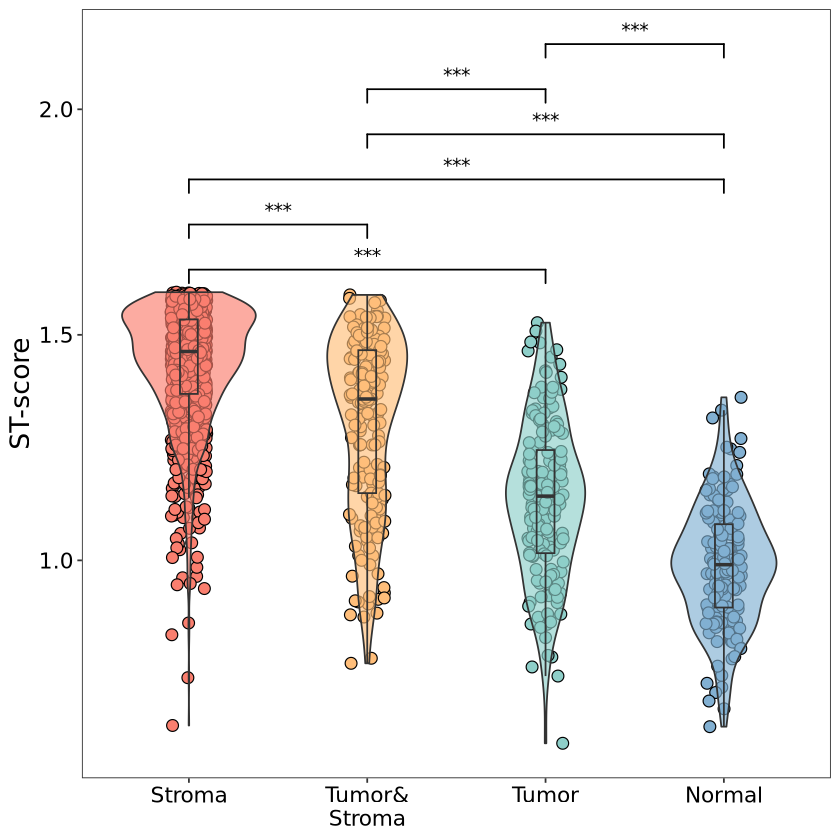

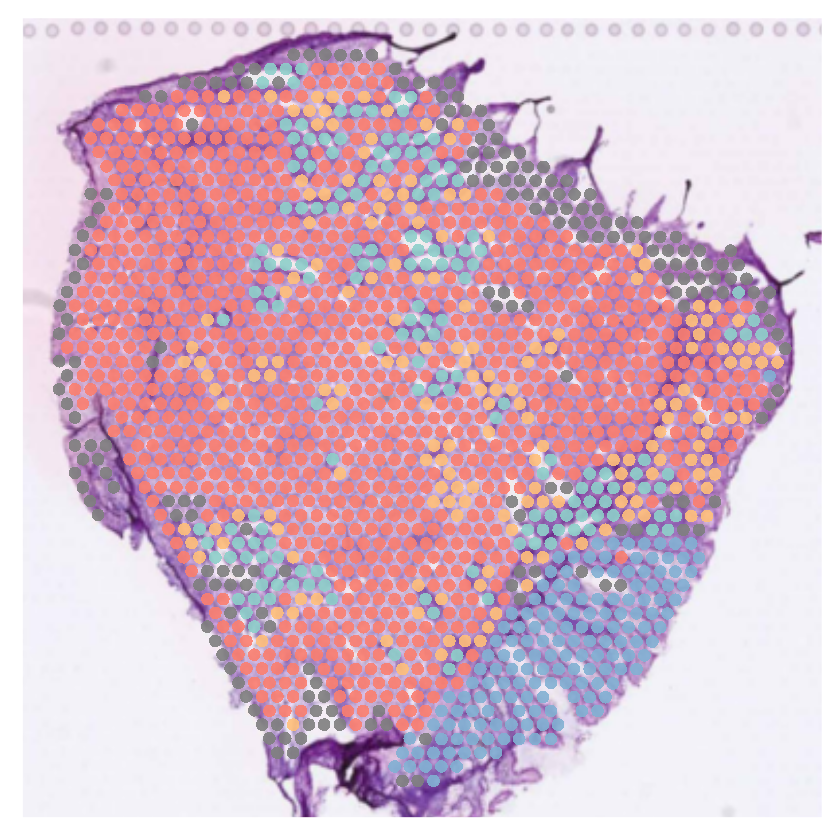

In [24]:
print(p1)
print(p)

In [26]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Debian GNU/Linux 12 (bookworm)

Matrix products: default
BLAS/LAPACK: ./anaconda3/envs/scCRC/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Berlin
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] ggsignif_0.6.4        viridis_0.6.4         viridisLite_0.4.2    
 [4] RColorBrewer_1.1-3    clusterProfiler_4.8.3 pheatmap_1.0.12      
 [7] lubridate_1.9.3       forcats_1.0.0         stringr_1.5.0        
[10] purrr_1